In [1]:
!pip uninstall -y langchain langchain-community langchain-core langchain-experimental langchain-openai langchain-qdrant qdrant-client ragas rank-bm25 langchain_cohere ragas

In [2]:
!pip install -q langchain==0.2.16 langchain-community==0.2.16 langchain-core==0.2.38 langchain-experimental==0.0.65 langchain-openai==0.1.23 langchain-qdrant==0.1.4 qdrant-client==1.11.3 ragas==0.1.20 rank-bm25==0.2.2 langchain_cohere

In [18]:
!pip install rank-bm25

In [3]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [21]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

In [5]:
from uuid import uuid4
from langchain_community.document_loaders import CSVLoader
from ragas.testset.generator import TestsetGenerator
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas.testset.evolutions import simple, reasoning, multi_context
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
)


/opt/miniconda3/envs/w7_d2_NEW/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Download data files
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2024-10-01 14:52:28--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0.001s  

2024-10-01 14:52:29 (31.3 MB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2024-10-01 14:52:29--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14747 (14K) [text/plain]
Sa

In [10]:
df = pd.read_csv(f"john_wick_{i}.csv", encoding='utf-8')
print(df.columns)  # Check the actual column names

Index(['Unnamed: 0', 'Review_Date', 'Author', 'Rating', 'Review_Title',
       'Review', 'Review_Url'],
      dtype='object')


In [12]:
# Load data into documents
documents = []

for i in range(1, 5):
    # Read CSV file
    df = pd.read_csv(f"john_wick_{i}.csv", encoding='utf-8')

    # Print column names to inspect them (for debugging)
    print(f"CSV {i} Columns:", df.columns)

    # Clean column names: convert to lowercase and strip spaces
    df.columns = df.columns.str.strip().str.lower()

    # Iterate through rows
    for _, row in df.iterrows():
        # Use 'review' as the content column
        content = row['review']
        metadata = {
            'review_date': row.get('review_date', ''),
            'review_title': row.get('review_title', ''),
            'review_url': row.get('review_url', ''),
            'author': row.get('author', ''),
            'rating': int(row.get('rating', 0)) if pd.notnull(row.get('rating')) else 0,
            'movie_title': f"John Wick {i}",
            'last_accessed_at': (datetime.now() - timedelta(days=4 - i)).isoformat()
        }
        documents.append(Document(page_content=content, metadata=metadata))


CSV 1 Columns: Index(['Unnamed: 0', 'Review_Date', 'Author', 'Rating', 'Review_Title',
       'Review', 'Review_Url'],
      dtype='object')
CSV 2 Columns: Index(['Unnamed: 0', 'Review_Date', 'Author', 'Rating', 'Review_Title',
       'Review', 'Review_Url'],
      dtype='object')
CSV 3 Columns: Index(['Unnamed: 0', 'Review_Date', 'Author', 'Rating', 'Review_Title',
       'Review', 'Review_Url'],
      dtype='object')
CSV 4 Columns: Index(['Unnamed: 0', 'Review_Date', 'Author', 'Rating', 'Review_Title',
       'Review', 'Review_Url'],
      dtype='object')


In [15]:
from qdrant_client import QdrantClient
from langchain.vectorstores import Qdrant
from langchain.embeddings import OpenAIEmbeddings

# Create embeddings
embeddings = OpenAIEmbeddings()

# Initialize Qdrant client (not passed to the Qdrant vectorstore)
qdrant_client = QdrantClient(location=":memory:")

# Create Qdrant vector store using the correct parameters
vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",  # Instead of passing the client, use location
    collection_name="JohnWick"
)


In [16]:
# Naive retriever
naive_retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

In [19]:
from rank_bm25 import BM25Okapi  # Import BM25Okapi from rank_bm25

# Prepare documents for BM25
tokenized_corpus = [doc.page_content.split() for doc in documents]
bm25 = BM25Okapi(tokenized_corpus)

class CustomBM25Retriever:
    def __init__(self, bm25, documents, k=10):
        self.bm25 = bm25
        self.documents = documents
        self.k = k

    def get_relevant_documents(self, query):
        tokenized_query = query.split()
        doc_scores = self.bm25.get_scores(tokenized_query)
        top_n = doc_scores.argsort()[-self.k:][::-1]
        return [self.documents[i] for i in top_n]

bm25_retriever = CustomBM25Retriever(bm25, documents)

In [75]:
import cohere

# Initialize Cohere client
cohere_client = cohere.Client(os.environ["COHERE_API_KEY"])

class CohereRerankRetriever:
    def __init__(self, base_retriever, cohere_client, top_n=5):
        self.base_retriever = base_retriever
        self.cohere_client = cohere_client
        self.top_n = top_n

    def get_relevant_documents(self, query):
        # Retrieve documents using base retriever
        docs = self.base_retriever.get_relevant_documents(query)
        if not docs:
            return []

        # Prepare inputs for reranking
        passages = [doc.page_content for doc in docs]

        # Call Cohere rerank API
        response = self.cohere_client.rerank(
            query=query,
            documents=passages,
            top_n=min(self.top_n, len(passages)),
            model="rerank-english-v2.0"
        )

        # Get reranked documents using 'index' instead of 'id'
        reranked_docs = [docs[item.index] for item in response.results]

        return reranked_docs

compression_retriever = CohereRerankRetriever(
    base_retriever=naive_retriever,
    cohere_client=cohere_client,
    top_n=5
)


In [25]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.chat_models import ChatOpenAI

# Initialize LLM for generating multiple queries
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Multi-Query Retriever without verbose argument
multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever,
    llm=llm
)

In [38]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain.text_splitter import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models
from operator import itemgetter
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI

# Define the RunnablePassthrough class
class RunnablePassthrough:
    @staticmethod
    def assign(context):
        return context

# Example: Define a prompt template for question answering
rag_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
    Context: {context}
    
    Question: {question}
    
    Please provide a helpful and concise answer.
    """
)

# Initialize the LLM model
chat_model = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore=parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

parent_document_retriever.add_documents(parent_docs, ids=None)

# Step 1: Query the parent document retriever for relevant documents
query = "Some question or query"  # Define your query here
retrieved_documents = parent_document_retriever.get_relevant_documents(query)

# Step 2: Extract the context (if applicable) from the retrieved documents
if retrieved_documents:
    retrieved_context = retrieved_documents[0].page_content  # Assuming you're working with page content
    retrieved_question = query  # The original query can be treated as the question
else:
    retrieved_context = ""
    retrieved_question = query

# Step 3: Pass the context through RunnablePassthrough
assigned_context = RunnablePassthrough.assign(context={"context": retrieved_context})

# Step 4: Generate a response using the prompt template and chat model
formatted_prompt = rag_prompt.format(context=retrieved_context, question=retrieved_question)

response = chat_model.predict(formatted_prompt)  # Generate the response using the LLM

# Output the final response (you can modify this based on your usage)
print(response)


/var/folders/9b/w4m3gwfn51z3r910zg6b_k4c0000gn/T/ipykernel_53045/1684451920.py:72: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use invoke instead.
  response = chat_model.predict(formatted_prompt)  # Generate the response using the LLM


What elements do you think are essential for creating a perfect action movie?


In [80]:
from langchain_core.runnables import Runnable

# Define a custom retriever that implements the required 'invoke' method
class CustomRunnableRetriever(Runnable):
    def __init__(self, retriever):
        self.retriever = retriever
    
    def _get_relevant_documents(self, query):
        return self.retriever.get_relevant_documents(query)
    
    def invoke(self, query, config=None):
        # Call the internal retrieval logic and return the documents
        return self._get_relevant_documents(query)

# Wrap each retriever in a CustomRunnableRetriever if it's not already a Runnable
wrapped_retrievers = [
    CustomRunnableRetriever(bm25_retriever),  # Wrapping each retriever manually
    CustomRunnableRetriever(naive_retriever),
    CustomRunnableRetriever(parent_document_retriever),
    CustomRunnableRetriever(compression_retriever),
    CustomRunnableRetriever(multi_query_retriever)
]

# Assign equal weighting to each retriever
equal_weighting = [1 / len(wrapped_retrievers)] * len(wrapped_retrievers)

# Initialize the Ensemble Retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=wrapped_retrievers,
    weights=equal_weighting
)


In [41]:
# Create a golden dataset (synthetic questions and ground truth answers)
golden_dataset = [
    {
        'query': "What are the common criticisms of John Wick 2?",
        'ground_truth': "Some reviewers felt that John Wick 2 had a weaker plot compared to the first movie, with excessive action overshadowing character development."
    },
    {
        'query': "How did reviewers feel about the action sequences in John Wick 3?",
        'ground_truth': "Reviewers praised the action sequences in John Wick 3, highlighting their creativity and intensity."
    },
    {
        'query': "Did reviewers think John Wick 4 was better than previous movies?",
        'ground_truth': "Many reviewers considered John Wick 4 to be a strong continuation of the series, with some stating it surpassed previous installments."
    },
    {
        'query': "What is the overall rating of John Wick 1?",
        'ground_truth': "John Wick 1 received high ratings from reviewers, often scoring above 8 out of 10."
    },
    {
        'query': "Are there any reviews that mention Keanu Reeves' performance?",
        'ground_truth': "Many reviews mention Keanu Reeves' performance, praising his portrayal of the character John Wick."
    },
]


In [81]:
import time
from datasets import Dataset  # Import the Hugging Face Datasets library

# Define the list of retrievers to evaluate
retrievers = {
    'Naive Retriever': naive_retriever,
    'BM25 Retriever': bm25_retriever,
    'Contextual Compression Retriever': compression_retriever,
    'Multi-Query Retriever': multi_query_retriever,
    'Parent Document Retriever': parent_document_retriever,
    'Ensemble Retriever': ensemble_retriever,
}

# Define the metrics to evaluate
metrics = [
    context_recall,
    context_precision,
    # You can add more metrics if available and compatible with your ragas version
]

# Initialize a dictionary to store results
results = {}

# Evaluate each retriever
for name, retriever in retrievers.items():
    print(f"Evaluating {name}...")
    latencies = []
    retrieved_answers = []

    # Define a retrieval function compatible with Ragas
    def retrieve_fn(query, retriever=retriever):
        start_time = time.time()  # Measure time
        docs = retriever.get_relevant_documents(query)
        latency = time.time() - start_time  # Calculate latency
        latencies.append(latency)   
        return [doc.page_content for doc in docs]

    # Collect retrieved documents for each query
    for item in golden_dataset:
        query = item['query']
        retrieved_docs = retrieve_fn(query)
        retrieved_answers.append(retrieved_docs)

    # Prepare evaluation data with required columns
    evaluation_data = []
    for retrieved, item in zip(retrieved_answers, golden_dataset):
        evaluation_data.append({
            'user_input': item['query'],  # Add the user input (query)
            'retrieved_contexts': retrieved,  # Add the retrieved contexts (documents)
            'ground_truth': item['ground_truth']
        })

    # Convert the list to a Hugging Face dataset
    evaluation_dataset = Dataset.from_list(evaluation_data)

    # Evaluate using Ragas
    scores = evaluate(evaluation_dataset, metrics)

    # Calculate average latency
    avg_latency = sum(latencies) / len(latencies) if latencies else 0

    # Store the results
    results[name] = {
        'scores': scores,
        'avg_latency': avg_latency
    }

# Display the results
for name, data in results.items():
    print(f"\nRetriever: {name}")
    scores = data['scores']
    avg_latency = data['avg_latency']
    print(f"  Average Latency: {avg_latency:.4f} seconds")
    for metric_name, score in scores.items():
        print(f"  {metric_name}: {score:.4f}")


Evaluating Naive Retriever...


Evaluating: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Evaluating BM25 Retriever...


Evaluating: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


Evaluating Contextual Compression Retriever...


Evaluating: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Evaluating Multi-Query Retriever...


Evaluating: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


Evaluating Parent Document Retriever...


Evaluating: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


Evaluating Ensemble Retriever...


Evaluating: 100%|██████████| 10/10 [00:26<00:00,  2.68s/it]



Retriever: Naive Retriever
  Average Latency: 0.1413 seconds
  context_recall: 1.0000
  context_precision: 0.5947

Retriever: BM25 Retriever
  Average Latency: 0.0006 seconds
  context_recall: 0.6000
  context_precision: 0.3707

Retriever: Contextual Compression Retriever
  Average Latency: 0.2787 seconds
  context_recall: 1.0000
  context_precision: 0.7675

Retriever: Multi-Query Retriever
  Average Latency: 1.7309 seconds
  context_recall: 1.0000
  context_precision: 0.5647

Retriever: Parent Document Retriever
  Average Latency: 0.2043 seconds
  context_recall: 0.8000
  context_precision: 0.8000

Retriever: Ensemble Retriever
  Average Latency: 2.5262 seconds
  context_recall: 1.0000
  context_precision: 0.5911


#### Analysis and Comparison
- Naive Retriever - Fast and inexpensive, but with moderate precision. Ideal for scenarios where perfect recall is important but precision can be sacrificed.
- BM25 Retriever - Extremely fast and low-cost, but sacrifices both recall and precision. Best for use cases prioritizing speed with lower accuracy requirements.
- Contextual Compression Retriever - A solid balance of accuracy and speed. Its cost is higher than simpler retrievers, but it delivers high precision with perfect recall, making it ideal for high-stakes use cases.
- Multi-Query Retriever - The most expensive option with high latency. Although it ensures perfect recall, the precision is lower than expected, and the higher cost and slower performance make it less suitable for this dataset.
- Parent Document Retriever - Strong performance with a good balance between recall and precision. It's an efficient and cost-effective option, suitable for cases where both accuracy and speed are important.
- Ensemble Retriever - High cost and slow performance, with only moderate precision despite perfect recall. The complexity of combining retrievers adds to both cost and latency without a clear precision advantage.


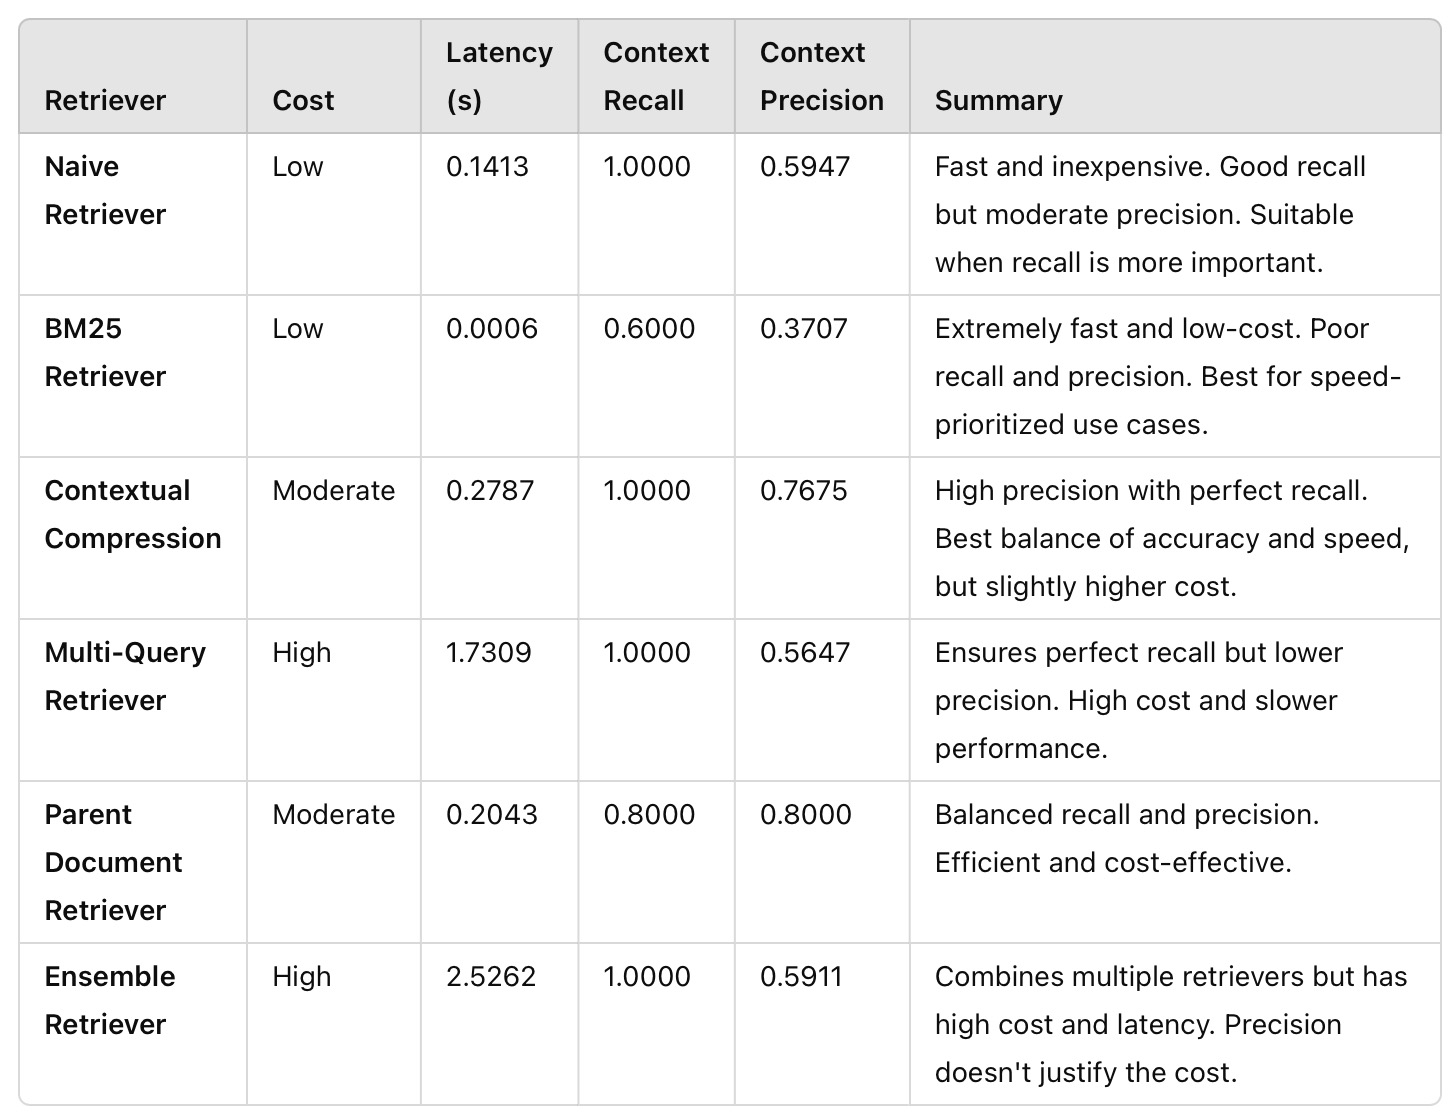

##### Key Takeaways
- Best Overall: Contextual Compression Retriever – perfect recall, high precision, moderate latency, and balanced cost.
- Fastest: BM25 Retriever – extremely low latency but sacrifices accuracy for speed.
- Best Precision: Parent Document Retriever – provides balanced precision and recall with moderate latency.
- Most Expensive: Multi-Query and Ensemble Retrievers – higher cost and latency, with only moderate precision.